# Eindimensionaler Kalman-Filter, Teil 2 Simulationen
5.4.2022, S. Mack

In [1]:
# display plots inside this notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

from collections import namedtuple
gaussian = namedtuple('Gaussverteilung', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

def update(prior, likelyhood):
    posterior = gaussian_multiply(likelyhood, prior)
    return posterior

Die beiden Funktionen ``update()`` und ``predict()`` aus dem letzten Notebook sind  oben aufgeführt. Dort findet sich auch der Quellcode für das Rechnen mit Gaußverteilungen. Mit diesem Code lässt sich nun ein Kalman-Filter realisieren, der einen Zustandswert mit der bekannten Vorhersage-/Korrektur-Iteration trackt.  
Damit der Filter getestet werden kann, müssen Messdaten simuliert werden. Daher wird im nächsten Abschnitt noch Code für die Simulation der Bewegung des Roboterfahrzeugs entwickelt. Die Algorithmen hierfür werden durch die Klasse ``RoboSim`` implementiert.

## Klasse RoboSim für Simulation von Messdaten 
Es soll ein Roboterfahrzeug simuliert werden, welches im Wesentlichen geradlinig entlang einer geraden Wand fährt. Dabei muss seine Fahrspur nicht parallel zur Wand sein.  
Von Interesse ist nicht mehr die Position entlang des Flurs sondern um die Position in Bezug auf die Wand: Es wird der Abstand zur Wand gemessen - diese Messgröße ist somit die zu filternde "Zustandsgröße". Auf diese Messgröße beziehen sich die nachfolgenden Variablen wie ``x0``, ``velocity`` usw.  
Es wird also **nicht der zurück gelegte Weg sondern der Abstand bzw. die Abständsänderung zur Wand** betrachtet. Fährt das Fahrzeug beispielsweise geradlinig schräg von der Wand weg, dann besitzt es eine konstante Geschwindigkeit ``velocity``, mit der es sich von der Wand weg bewegt.

Der Konstruktor ``RoboSim(x0,velocity,measurement_var,process_var)`` erhält folgende Variablen übergeben: 
* ``x0``: Startposition des Roboters, also der anfängliche Abstand zur Wand. 
* ``velocity``: Die (mittlere) Positionsänderung pro Iteration, also der Erwartungswert der Abstandsänderung zur Wand.
* ``process_var``: Die Varianz des gaussförmigen Prozessrauschens, mit dem ``velocity`` beaufschlagt wird. Der Roboter bewegt sich realitätsnah *nicht* mit absolut konstanter Geschwindigkeit relativ zur Wand. D.h. er fährt beispielsweise leichte Schlangenlinien im Gegensatz zu einer idealen Fahrspur in Form einer Geraden.
* ``measurement_var``: Die Varianz der Messunsicherheit des Positionssensors, also des Messrauschens.  
  
Die Methode `sense_position()` schlägt auf den schon durch das Prozessrauschen verrauschten wahren Positionswert zusätzlich ein Messrauschen auf.

In [2]:
import copy # needed for deepcopy() ín move_and_sense()
class RoboSim(object):

    def __init__(self, x0=0, velocity=1, process_var=0.0, measurement_var=0.0):
        ''' x0 - initial position, velocity - (+=right, -=left), process_variance - variance 
        velocity of process (m/s)^2, measurement_variance - variance in measurement m^2 '''
        self.x = x0
        self.velocity = velocity
        self.measurement_noise = np.sqrt(measurement_var)
        self.process_noise = np.sqrt(process_var)

    def move(self, dt=1.0):
        '''compute new position of the robot assuming `dt` seconds have passed since the last update
        based on (velocity + process noise).'''
        velocity = self.velocity + np.random.randn() * self.process_noise * dt
        self.x += velocity * dt

    def sense_position(self):
        # simulates measuring the position with measurement noise
        return self.x + np.random.randn() * self.measurement_noise

    def move_and_sense(self, dt=1.0):
        self.move(dt)
        x = copy.deepcopy(self.x)
        return x, self.sense_position() # true noisy position and measured position of robot

    def run_simulation(self, dt=1, count=1):
        ''' simulate the robot moving over a period of time and returns data: np.array[float, float],2D array, 
        column 0: true actual position of robot, column 1: measurement of robot position
        '''
        return np.array([self.move_and_sense(dt) for i in range(count)])

Im Quellcode oben ist es wichtig, den Unterschied zwischen dem Prozessrauschen und dem Messrauschen zu erkennen: 
>Das Prozessrauschen bewirkt, dass der Roboter sich nicht absolut gleichförmig bewegt. Diese schon "verrauschte" wahre Position wird von einem Sensor mit Messunsicherheit (= Messrauschen) gemessen und dadurch zusätzlich "verrauscht".

Der Rückgabewert der Funktion ``run_simulation`` ist ein Array aus Tupeln. Jedes Arrayelement entspricht einem Zeitschritt. In zugehörigen Tupel befindet sich an Position 0 der wahre Abstandswert und an Position 1 der gemessene Abstandswert des Roboters.

Nachfolgend wird mit der Klasse ``RoboSim`` eine Fahrt des Roboterfahrzeugs simuliert und grafisch dargestellt.

### Beispiel Simulation Roboterfahrzeug

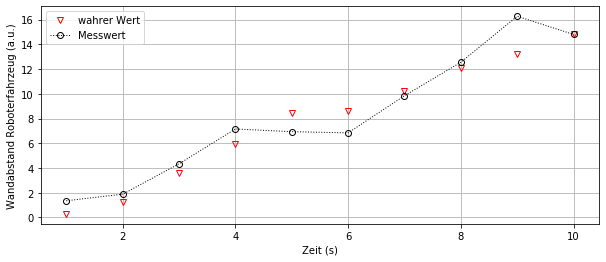

In [3]:
np.random.seed(13) # to make the simulation reproducible

process_var = 1. # variance of robot velocity, same as later in Kalman filter
sensor_var = 2. # variance distance sensor, same as later in Kalman filter

n = 10 # number of date to be simulated
x_start = 0
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity, process_var) # for simulation same parameters as later in Kalman filter
  
# simulate robot and get measurements
robot = RoboSim(x0=x_start,velocity=process_model.mean,measurement_var=sensor_var,process_var=process_model.var)

# create list of measurements
zs = [robot.move_and_sense() for _ in range(n)] # column 0: true position, column 1: measurend position

fig, ax = plt.subplots(figsize=(10,4))
time = np.linspace(dt,n*dt, n)
ax.plot(time, [z[0] for z in zs], color='r', mfc='None', marker = 'v', linestyle='None',label='wahrer Wert')
ax.plot(time, [z[1] for z in zs], color='k', mfc='None', marker = 'o', linestyle=':', linewidth = 1, label='Messwert')
ax.set_xlabel('Zeit (s)')
ax.set_ylabel('Wandabstand Roboterfahrzeug (a.u.)')
ax.legend()    
ax.grid()

Auf die oben simulierten Daten des Roboterfahrzeugs wird nun ein Kalman-Filter angewendet und dessen Wirkung untersucht. Dafür werden zuerst aber noch zwei Hilfsfunktionen benötigt.

## Hilfsfunktionen
### Plotfunktion für Ergebnisse Simulation mit Kalman-Filter
Nachfolgend wird eine Plotfunktion erstellt, die für die kommenden Simulationen den Verlauf der Vorhersagewerte, Messwerte und Schätzwerte (=Filteroutput) grafisch darstellt.  

In [4]:
def plot_meas_pred_est(measurements, predictions, estimates, est_vars):
    plt.figure(figsize=(10,4))
    n = len(measurements)
    time = range(1,n+1)
    meas, = plt.plot(time, measurements, color='k', mfc='None', marker = 'o', linestyle='None') # mfc = hollow markers
    pred, = plt.plot(time, predictions, color='k', mfc='None', marker = '+', linestyle='None')
    est, = plt.plot(time, estimates, marker = 'o', linestyle=':', linewidth = 2, markersize=3)
    est_var_min = np.asarray(estimates) - np.asarray(est_vars) # conversion to np.array because adding lists not possible
    est_var_max = np.asarray(estimates) + np.asarray(est_vars)
    plt.fill_between(time, est_var_min, est_var_max, facecolor='C0', alpha=0.2)
    
    plt.legend([meas, pred, est], ['Messwerte','Vorhersagewerte','Schätzwerte (Filter) $\pm \sigma$'], loc="upper left", 
               bbox_to_anchor=(1,1))
    plt.xlabel('Zeit (s)')
    plt.ylabel('Zustandswert (a.u.)')
    plt.grid()

Auch für den Kalmanfilter wird eine Funktion erstellt, damit die Quellcodes in diesem Notebook überschaubar bleiben. Die nachfolgende Funktion ``kal_filt_for_plot()`` filtert die übergebenen Messdaten aus ``zs`` (Position 0 der einzelnen Tupel dieser Liste) und gibt Arrays für die grafische Darstellung zurück.

### Funktion für Anwendung des Kalman-Filters auf Simulationsdaten inkl. Ergebnisplot

In [5]:
def kal_filt_for_plot(meas_data, est_start, est_start_var, process_model, sensor_var):
    posterior = gaussian(est_start, est_start_var)  # first initial guess of Robot position
    priors=[] # needed for subsequent plotting
    measurements=[]
    posteriors=[]
    post_vars=[]

    print('Wahr \t Vorhers. +/-Var      Mess +/-Var        Korr. +/-Var')

    # perform Kalman filter on measurement z, process_model and sensor_var values same as for simulation.
    for z in meas_data:    
        prior = predict(posterior, process_model)
        likelihood = gaussian(z[1], sensor_var)
        posterior = update(prior, likelihood)
        print('{:6.3f}\t {:6.3f} +/-{:7.3f}    {:6.3f} +/-{:6.3f}\t  {:6.3f} +/-{:6.3f}'.format
              (z[0],prior.mean, prior.var,z[1],sensor_var,posterior.mean,posterior.var))
        priors.append(prior.mean)
        posteriors.append(posterior.mean)
        post_vars.append(np.sqrt(posterior.var))
        measurements.append(z[1])
    
    #plot_meas_pred_est(measurements,priors,posteriors,post_vars)
    print()
    print('final estimate:        {:10.3f}'.format(posterior.mean))
    print('actual final position: {:10.3f}'.format(robot.x))
    return measurements,priors,posteriors,post_vars

## Vorbemerkung zu den nachfolgenden Simulationen
In den nachfolgend gezeigten Simulationsbeispielen erhält der Kalman-Filter für sein physikalisches Modell die selbe Geschwindigkeit ``velocity`` und Varianz ``process_var`` wie sie für die Simulation der Roboterbewegung verwendet wurde. Das Gleiche gilt auch für das Sensorrauschen: Das im Kalman-Filter angenommene Messwertrauschen ``sensor_var`` ist gleich zu dem simulierten Sensorrauschen ``measurement_var``.  
Diese Tatsache hat ein wenig den Beigeschmack einer Täuschung, denn bei einem realen, nicht simulierten Fahrzeug liegen diese Werte nicht vor. Letztlich kann man aber sowohl das Fahrzeug als auch den Sensor empirisch untersuchen, und erhält so Informationen zumindest zu den beiden Varianz-Parametern. 

**Der Parameter Geschwindigkeit im physikalischen Modell ist hier unveränderlich auf den Wert 1 festgelegt.**
Damit er ähnlich wie beim g-h-Filter dynamisch angepasst werden kann, muss der Kalman-Filter diesen Zustandswert ebenfalls schätzen. Dafür ist aber ein *zweidimensionaler* Kalmanfilter nötig, der erst im nächsten Jupyter
Notebook entwickelt wird.   

## Simulation mit zehn Iterationen zur Verdeutlichung der Filterwirkung

Wahr 	 Vorhers. +/-Var      Mess +/-Var        Korr. +/-Var
 0.288	  1.000 +/-401.000     1.354 +/- 2.000	   1.352 +/- 1.990
 1.243	  2.352 +/-  2.990     1.882 +/- 2.000	   2.070 +/- 1.198
 3.588	  3.070 +/-  2.198     4.341 +/- 2.000	   3.736 +/- 1.047
 5.938	  4.736 +/-  2.047     7.156 +/- 2.000	   5.960 +/- 1.012
 8.417	  6.960 +/-  2.012     6.939 +/- 2.000	   6.949 +/- 1.003
 8.628	  7.949 +/-  2.003     6.844 +/- 2.000	   7.396 +/- 1.001
10.191	  8.396 +/-  2.001     9.847 +/- 2.000	   9.122 +/- 1.000
12.105	 10.122 +/-  2.000    12.553 +/- 2.000	  11.338 +/- 1.000
13.232	 12.338 +/-  2.000    16.273 +/- 2.000	  14.305 +/- 1.000
14.838	 15.305 +/-  2.000    14.800 +/- 2.000	  15.053 +/- 1.000

final estimate:            15.053
actual final position:     14.838


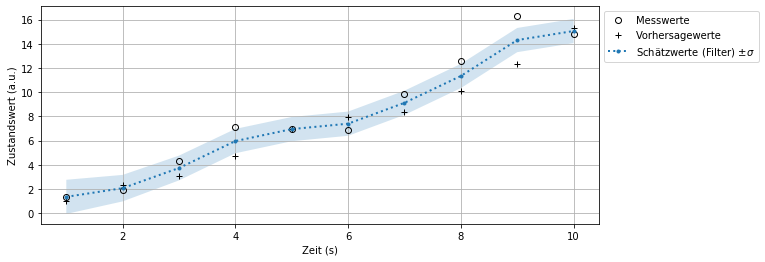

In [6]:
np.random.seed(13) # to make the simulation reproducible
est_start = 0
est_start_var = 400

process_var = 1. # variance of robot velocity, same as later in Kalman filter
sensor_var = 2. # variance distance sensor, same as later in Kalman filter

x_start = 0
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity, process_var) # for simulation same parameters as later in Kalman filter
  
# simulate robot and get measurements
robot = RoboSim(x0=x_start,velocity=process_model.mean,measurement_var=sensor_var,process_var=process_model.var)

# create list of measurements
zs = [robot.move_and_sense() for _ in range(10)] # column 0: true position, column 1: measurend position
# perform Kalman tracking and plot results, * needed to unpack arguments out of the list
plot_meas_pred_est(*kal_filt_for_plot(zs,est_start,est_start_var,process_model,sensor_var))

Die wahren Roboterpositionen wurden mit der Klasse ``RoboSim`` simuliert. Die Startposition ist 0, die Geschwindigkeit 1. Mit der selben Klasse wurden auch die Messwerte simuliert: Sie streuen relativ zu den wahren Abstandswerten (die auch schon streuen) mit einer Varianz von 2.    
Der Startpostionswert des Filters beträgt 0 und hat eine Varianz von 400. Dieser Wert ist der Schätzwert zur Zeit 0, welcher nicht im Plot und auch nicht oben in der Tabelle dargestellt ist. Die große Varianz bedeutet, dass das Roboterfahrzeug am Anfang praktisch überall vermutet wird.    
Der erste Vorhersagewert ist gleich 1, denn im Prozessmodell ist eine feste Geschwindigkeit von 1/s angenommen und der Zeitschritt beträgt 1 s. Die Varianz dieses ersten Vorhersagewerts ist mit 401 sogar noch um 1 höher als die Varianz des Startwerts.  
Der Schätzwert für die Zeit 1 liegt deshalb sehr nahe am Messwert (und nicht am Vorhersagewert), da dessen Varianz mit (konstant) 2 wesentlich kleiner ist als die des Vorhersagewerts (401).  
Bei den nächsten Iterationen (=Zeitschritten) liegt der Schätzwert wie erwartet immer zwischen dem Vorhersagewert und dem Messwert.
  
Die Standardabweichung (*also die Wurzel der Varianz!*) des Schätzwertes ist durch das hellblaue Band markiert und engt sich rasch auf den Wert 1 ein: Die Varianz des Messwerts ist konstant 2 und die Varianz des Vorhersagewerts konvergiert gegen den Wert 2. Die Kombination dieser beiden Varianzen lässt sich als Mittelwertbildung aus zwei unabhängigen Zufallswerten mit Varianz 2 auffassen. Somit ergibt sich für den Mittelwert die halbe Varianz von 1, was gleich einer Standardabweichung von 1 ist.
> Die Varianz des des Filter-Outputs (Korrekturwert=Schätzwert) ist schon bei der zweiten Iteration deutlich kleiner als die Varianz des Messwerts. Der Kalman-Filter zeigt also große Wirkung. Zudem liegt der wahre Wert immer innerhalb des 68 % Vertrauensintervalls des Filter-Outpus.
  
Die Varianz des Vorhersagewerts nähert sich rasch dem Wert 2, da jeweils die Varianz 1 des Prozessmodells zur vorherigen Varianz des Schätzwerts hinzu kommt.

## Kalman-Filter für Simulation mit hohem Prozessrauschen

```python
process_var = 40
sensor_var = 2
```
Hier ist die Varianz des Messwerts auf lange Sicht gleich ``sensor_var``, denn die Vorhersage wird wegen ihrer ungleich höheren Unsicherheit nicht mehr ernst genommen. 

Wahr 	 Vorhers. +/-Var      Mess +/-Var        Korr. +/-Var
-3.506	  1.000 +/-440.000    -2.440 +/- 2.000	  -2.424 +/- 1.991
-2.787	 -1.424 +/- 41.991    -2.148 +/- 2.000	  -2.115 +/- 1.909
 6.720	 -1.115 +/- 41.909     7.473 +/- 2.000	   7.082 +/- 1.909
16.259	  8.082 +/- 41.909    17.477 +/- 2.000	  17.049 +/- 1.909
26.612	 18.049 +/- 41.909    25.133 +/- 2.000	  24.810 +/- 1.909
22.622	 25.810 +/- 41.909    20.837 +/- 2.000	  21.064 +/- 1.909
27.181	 22.064 +/- 41.909    26.837 +/- 2.000	  26.620 +/- 1.909
33.960	 27.620 +/- 41.909    34.409 +/- 2.000	  34.100 +/- 1.909
35.765	 35.100 +/- 41.909    38.807 +/- 2.000	  38.638 +/- 1.909
40.600	 39.638 +/- 41.909    40.562 +/- 2.000	  40.520 +/- 1.909

final estimate:            40.520
actual final position:     40.600


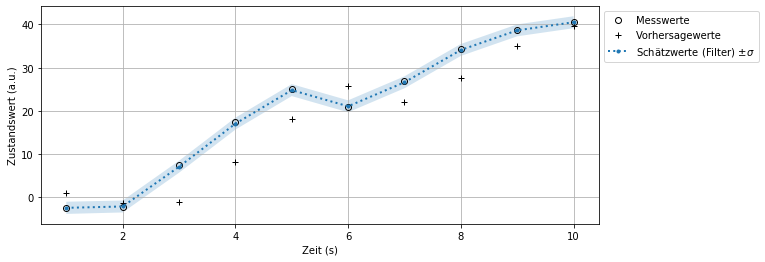

In [7]:
np.random.seed(13) # to make the simulation reproducible
est_start = 0
est_start_var = 400

process_var = 40.
sensor_var = 2.

x_start = 0
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity, process_var) # for simulation same parameters as later in Kalman filter
  
# simulate robot and get measurements
robot = RoboSim(x0=x_start,velocity=process_model.mean,measurement_var=sensor_var,process_var=process_model.var)

# create list of measurements
zs = [robot.move_and_sense() for _ in range(10)] # column 0: true position, column 1: measurend position
# perform Kalman tracking and plot results, * needed to unpack arguments out of the list
plot_meas_pred_est(*kal_filt_for_plot(zs,est_start,est_start_var,process_model,sensor_var))

## Kalman-Filter für Simulation mit hohem Sensorrauschen

```python
process_var = 2
sensor_var = 40
```
Hier ist die Varianz des Korrekturwerte auf lange Sicht etwa 8. Es stellt sich ein Gleichgewicht ein: Die Vorhersagewerte liegen bei einer Varianz von ca. 10, was mit der konstanten Varianz 40 der Messwerte zu einer resultierenden Varianz von 8 kombiniert wird.

Wahr 	 Vorhers. +/-Var      Mess +/-Var        Korr. +/-Var
-0.007	  1.000 +/-402.000     4.760 +/-40.000	   4.420 +/-36.380
 0.930	  5.420 +/- 38.380     3.787 +/-40.000	   4.620 +/-19.587
 3.832	  5.620 +/- 21.587     7.199 +/-40.000	   6.173 +/-14.020
 6.741	  7.173 +/- 16.020    12.188 +/-40.000	   8.608 +/-11.439
 9.832	  9.608 +/- 13.439     3.221 +/-40.000	   8.001 +/-10.059
 9.717	  9.001 +/- 12.059     1.738 +/-40.000	   7.319 +/- 9.266
11.513	  8.319 +/- 11.266     9.974 +/-40.000	   8.682 +/- 8.790
13.805	  9.682 +/- 10.790    15.812 +/-40.000	  10.985 +/- 8.498
14.985	 11.985 +/- 10.498    28.585 +/-40.000	  15.436 +/- 8.315
16.842	 16.436 +/- 10.315    16.673 +/-40.000	  16.484 +/- 8.201

final estimate:            16.484
actual final position:     16.842


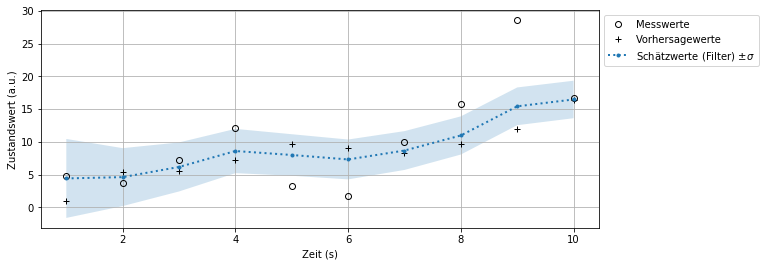

In [8]:
np.random.seed(13) # to make the simulation reproducible
est_start = 0
est_start_var = 400

process_var = 2.
sensor_var = 40.

x_start = 0
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity, process_var) # for simulation same parameters as later in Kalman filter
  
# simulate robot and get measurements
robot = RoboSim(x0=x_start,velocity=process_model.mean,measurement_var=sensor_var,process_var=process_model.var)

# create list of measurements
zs = [robot.move_and_sense() for _ in range(10)] # column 0: true position, column 1: measurend position
# perform Kalman tracking and plot results, * needed to unpack arguments out of the list
plot_meas_pred_est(*kal_filt_for_plot(zs,est_start,est_start_var,process_model,sensor_var))

## Kalmanfilter mit unpassendem Prozessmodell
Nachfolgend wird untersucht, wie ein Kalman-Filter reagiert, wenn die Messdaten ganz und gar nicht zum Prozessmodell passen.
Dazu wird die Klasse RoboSim so modifiziert, dass der Roboter sich nun nicht mehr gleichförmig sondern mit konstanter Beschleunigung bewegt. Dazu wird eine Klasse RoboSimAcc erstellt, die von der Klasse RoboSim erbt.    

In [9]:
class RoboSimAcc(RoboSim):
    def __init__(self, x0=0, velocity=1, accel = 1, process_var=0.0, measurement_var=0.0):
        ''' x0 - initial position, velocity - (+=right, -=left), process_variance - variance in process (m/s)^2, 
        measurement_variance - variance in measurement m^2 '''
        super().__init__(x0=0, velocity=1, process_var=0.0, measurement_var=0.0)
        self.accel = accel
        
    def move(self, dt=1.0):
        '''compute new position of the robot assuming `dt` seconds have passed since the last update.'''
        # computes new position based on velocity and acceleration + process noise added
        self.velocity = self.velocity + self.accel * dt
        velocity = self.velocity + np.random.randn() * self.process_noise * dt
        self.x += velocity * dt

Das Prozessmodell des Kalman-Filters basiert jedoch anders als die im Code oben erzeugten Simulationswerte immer noch auf einer gleichförmigen Bewegung. **Im Gegensatz zu den vorangegangenen Abschnitten verwendet die Simulation der Roboterbewegung also einen ganz anderen Geschwindigkeitsverlauf als das Prozessmodell des Kalman-Filters.** 
Wie der nachfolgende Plot darstellt, kann nun der Kalman-Filter der beschleunigten Bewegung nicht folgen, da er ja von einer gleichförmigen Bewegung ausgeht. Das Gleiche wurde auch beim gh-Filter gezeigt. Der wahre Wert liegt ab der dritten Iteration immer außerhalb des 68 % Vertrauensintervalls des Filter-Outpus.
Nur wenn das Prozessrauschen sehr viel größer als das Sensorrauschen gewählt wird, folgen die Schätzwerte dem Parabelverlauf. Dann aber findet jedoch fast gar keine Filterwirkung statt.

Wahr 	 Vorhers. +/-Var      Mess +/-Var        Korr. +/-Var
 2.000	  1.000 +/-401.000     2.000 +/- 2.000	   1.995 +/- 1.990
 5.000	  2.995 +/-  2.990     5.000 +/- 2.000	   4.196 +/- 1.198
 9.000	  5.196 +/-  2.198     9.000 +/- 2.000	   7.188 +/- 1.047
14.000	  8.188 +/-  2.047    14.000 +/- 2.000	  11.128 +/- 1.012
20.000	 12.128 +/-  2.012    20.000 +/- 2.000	  16.075 +/- 1.003
27.000	 17.075 +/-  2.003    27.000 +/- 2.000	  22.041 +/- 1.001
35.000	 23.041 +/-  2.001    35.000 +/- 2.000	  29.022 +/- 1.000
44.000	 30.022 +/-  2.000    44.000 +/- 2.000	  37.011 +/- 1.000
54.000	 38.011 +/-  2.000    54.000 +/- 2.000	  46.006 +/- 1.000
65.000	 47.006 +/-  2.000    65.000 +/- 2.000	  56.003 +/- 1.000

final estimate:            56.003
actual final position:     65.000


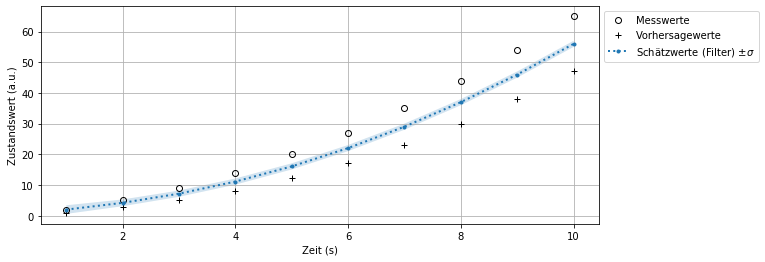

In [13]:
np.random.seed(13) # to make the simulation reproducible
est_start = 0
est_start_var = 400

process_var = 1. # variance of robot velocity, same as later in Kalman filter 1
sensor_var = 2. # variance distance sensor, same as later in Kalman filter 2

x_start = 0
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity, process_var) # for simulation same parameters as later in Kalman filter
  
# simulate robot and get measurements
robot = RoboSimAcc(x0=x_start,velocity=process_model.mean,accel = 1,measurement_var=sensor_var,process_var=process_model.var)

# create list of measurements
zs = [robot.move_and_sense() for _ in range(10)] # column 0: true position, column 1: measurend position
# perform Kalman tracking and plot results, * needed to unpack arguments out of the list
plot_meas_pred_est(*kal_filt_for_plot(zs,est_start,est_start_var,process_model,sensor_var))

## Allgemeine Notation und Bezeichnungen für den Kalman-Filter in der Literatur

Es gibt viele, auch gute Lehrbücher zum Kalman-Filter. Sie haben aber fast alle gemeinsam, dass sie zuerst die Theorie behandeln und erst dann den tapferen Leser mit praktischen Beispielen belohnen.  
In diesen Notebooks wird bewusst auf die "reine Theorie" verzichtet. Der Kalman-Filter wurde hier Schritt für Schritt intuitiv mit vielen Beispielen und Simulationen entwickelt.  

Will man sich näher mit dem Kalman-Filter befassen und auch die Theorie dahinter verstehen, dann ist es wichtig, die Notationen und Bezeichnungen aus der Literatur den Bezeichnungen in diesen Notebooks zuordnen zu können. Dies ist der Sinn und Zweck dieses Abschnitts.  
Generell gilt im vorliegenden Jupyter Notebook: Ein Dach $\hat \quad$ über einer Größe bezeichnet deren Wert nach der Korrektur. Ein Balken $\bar \quad$ über einer Größe bezeichnet deren Wert nach der Vorhersage.

Im Korrekturschritt sind sowohl der Vorhersagewert als auch der Messwert Gaußverteilungen, die jeweils über einen Erwartungswert $\bar\mu$ bzw. $\mu_z$ und eine Varianz $\bar\sigma^2$ bzw. ${\sigma_z}^2$ definiert werden.  

Der Korrekturwert (auch Posterior oder Schätzwert genannt) wird über folgende Formel berechnet:

$$
\hat\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2}
$$

Dies kann umgeformt werden zu:

$$\hat\mu = \left( \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma^2 + \sigma_z^2}\right)\bar\mu$$

Letztlich sieht man oben wieder wie beim g-h-Filter einen gewichteten Mittelwert aus Vorhersagewert und Messwert. Aus den beiden Gewichtungsfaktoren in den Klammern wird nun wie beim beim g-h-Filter ein Gain berechnet, der dem Parameter $g$ des g-h-Filters entspricht: 

Mit 
$$K=\frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}$$ 
ergibt sich:

$$\begin{aligned}
\hat\mu &= K \mu_z + (1-K) \bar\mu\\
&= \bar\mu + K(\mu_z - \bar\mu)
\end{aligned}$$

> $K$ wird in der Literatur als *Kalman gain* bezeichnet. Er ist das Verhältnis der Gewichtung des Vorhersagewerts im Vergleich zum Messwert.

Der dem g-h-Filter entsprechende Parameter $h$ wird hier übrigens noch nicht implementiert - im phyiskalischen Modell diese *eindimensionalen* Kalman-Filters wird die Abständsänderung nicht dem Messwertverlauf angepasst sonder immer gleich 1 angenommen.

### Neuimplementierung der Kalman-Filter-Iterationsschritte "update" und "predict"
Nachfolgend sind neue Implementierungen der Funktionen ``update()`` and ``predict()`` dargestellt. Vom Algorithmus her sind sie identisch zu denen am Beginn dieses Notebooks. Hier werden lediglich die Bezeichnungen denen der in der Literatur angepasst.

In [11]:
def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance, product of two gaussians
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q # prior, sum of two gaussions
    return gaussian(x, P)

Zum besseren Verständnis ist nachfolgend nochmals eine Iteration aus Vorhersage und Korrektur grafisch dargestellt.  
>Der Kalman Gain $K$ bestimmt, wo der neue Schätzwert entlang des Residuums zu liegen kommt.  

<img src="grafikKalman_VorhersKorr.png" width="800">  

In der vorherigen Notation war $z = \mu_z$ und $\bar x_t = \bar \mu$.

Die im Quellcode verwendeten Bezeichnungen ``z``, ``P``, ``Q`` und ``R`` findet man sehr oft in Literatur zum Kalman-Filter. Sie sind eine Standardnotation für den Kalman-Filter.
+ $z$ steht meistens für den Messwert.
+ $R$ steht für Varianz des Messwerts.
+ $Q$ steht für Varianz des Prozesses.
+ $P$ steht für die Varianz des Zustands, mit Balken $\bar P$ des Priors (Vorhersagewert) bzw. mit Dach $\hat P$ des Posteriors (Korrekturwert)

### Korrespondenz der Bezeichnungen zum Buch "Kalman-Filter" von R. Marchthaler  und S. Dingler
Dieses aktuelle Buch bietet die Möglichkeit, sich tiefer in den Thematik des Kalman-Filters einzuarbeiten. Hier sind auch die nötigen theoretischen Grundlagen erklärt.  
Damit der Umstieg von dieser Notebookreihe auf das Fachbuch gelingt, sind in der Tabelle die Begrifflichkeiten verglichen.


| Parameter in diesem Notebook | entsprechender Parameter Marchthaler |            Bemerkung            |
| :--------------------------- | :----------------------------------: | -------------------------------:|
| Prior, Vorhersagewert $\bar x$ | prädizierter Zustandsvektor $\hat {\underline x}(k)$ | Ausgang predict()<br/>selbe Messgröße wie z|
| Varianz Prior $\bar P$ | prädizierte Kovarianz des Schätzfehlers $\hat{\underline P}(k)$ | Ausgang predict() |
| Posterior, Korrekturwert $\hat x$ | Korrigierter Zustandsvektor $\tilde {\underline x}(k)$ | Ausgang update() |
| Varianz Posterior $\hat P$ | korrigierte Kovarianz des Schätzfehlers $\tilde{\underline P}(k)$ | Ausgang update() |
| Messwert z | Ausgangsvektor ${\underline y}(k)$| hier Abstand |
| Varianz Messwert R | Varianz Messrauschen ${\underline R}(k)$ | hier const. |
| - | prädizierter Messwert $\hat {\underline y}(k)$| = $\underline C \cdot \hat {\underline x}(k)$ meist = $\hat {\underline x}(k)$ |
| Bewegung dx | steckt in Systemmatrix ${\underline {A_d}}(k)$| hier: v = const., im Buch: $f(v,a) \neq $const.|
| Varianz Prozess Q | Systemrauschen ${\underline Q}(k)$ | Zunahme Varianz Prior x durch Prädiktion |
| Kalman Gain K | Kalmanverstärkung ${\underline K}(k)$ | Input $\hat {\underline P}(k) , {\underline R}(k)$ |
| Residuum y | $\Delta \underline y(k)$ | engl. "residual" |

In der Einleitung dieses Buchs ist am Beispiel der Mondlandefähre der Kalmanfilter erklärt. Hier handelt es sich aber im Gegensatz zu diesem Notebook um einen zweidimensionalen Kalmanfilter, bei dem der Zustandsvektor nicht aus dem einen Element einer Ortskoordinate sondern aus der Ortskoordinate h, der Geschwindigkeit v und der Beschleunigung a besteht. Messwerte existieren nur für h und a. v ist durch die Matrix C immer gleich Null. Das bedeutet, dass v zwar eine Zustandsgröße aber kein Messwert ist.  
Die Rolle des Eingangsvektors $\underline u(k)$ ist im Buch ebenfalls unklar. Vermutlich hat dieser Vektor rein gar nichts mit dem Filteralgorithmus selbst zu tun. Auch dem Autor dieses Notebooks fällt es übrigens sehr schwer, die reine Theorie eines Kalmanfilters aus dem Buch von Marchthaler et al. zu verstehen ;-)

### Die Gleichungen und Implementierungen für einen Kalman-Filter

Zu Übersicht sind hier nochmals die verschiedenen Gleichungen aufgeführt, die in diesem und den voran gegangenen Notebook im Zusammenhang mit dem Kalman-Filter aufgetaucht sind:


<u>Vorhersage</u>

$\begin{array}{|l|l|l|}
\hline
\text{Gleichung} & \text{Implementierung} & \text{Kalman-Form}\\
\hline
 \bar x = \hat x + f_x & \bar\mu = \hat\mu + \mu_{f_x} & \bar x = \hat x + dx\\
& \bar\sigma^2 = \sigma^2 + \sigma_{f_x}^2 & \bar P = \hat P + Q\\
\hline
\end{array}$


<u>Korrektur</u>

$\begin{array}{|l|l|l|}
\hline
\text{Gleichung} & \text{Implementierung}& \text{Kalman-Form}\\
\hline
 \hat x = \| \mathcal L \circ  \bar x\| & y = \mu_z - \bar\mu & y = z - \bar x\\
 & K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2} & K = \frac {\bar P}{\bar P+R}\\
 & \hat\mu = \bar \mu + Ky & \hat x = \bar x + Ky\\
 & \sigma^2 = \frac {\bar\sigma^2 \sigma_z^2} {\bar\sigma^2 + \sigma_z^2} & \hat P = (1-K)\bar P\\
\hline
\end{array}$

### Der generische Algorithmus eines Kalman-Filters

>Ein Kalman-Filter erstellt eine Vorhersage, macht eine Messung und berechnet daraus einen Korrekturwert (auch Schätzwert genannt), der zwischen dem Vorhersagewert und dem Messwert liegt.  
Egal welches Lehrbuch über Kalman-Filter man aufschlägt, zugrunde liegt immer dieser Algorithmus. Er wird nur unterschiedlich mathematisch implementiert. So unterscheiden sich die verschiedenen Lehrbücher und Implementierungen im Wesentlichen in der verwendeteten Mathematik *jedoch nicht im Algorithmus*.

Dieser generische Kalman-Filter-Algorithmus lässt sich in neun Schritten beschreiben: 
  
**Initialisierung**

1. Ein physikalisches Modell erstellen und daraus eine mathematische Berechnungsformel für die Vorhersage ableiten.
2. Einen Startwert der Zustandsgröße (Wert, Unsicherheit) willkürlich festlegen.
    
**Vorhersage**

1. Den Zustandswert (Prior) für den nächsten Zeitschritt mit Hilfe es Prozessmodells vorhersagen.
2. Die Unsicherheit des Prozessmodells in die Unsicherheit des Vorhersagewerts einfließen lassen.
    
**Korrektur**

1. Eine Messung durchführen und wenn möglich deren Unsicherheit bestimmen, falls diese nicht als konstant angenommen wird.
2. Das Resuiduum von Messwert minus Vorhersagewert berechnen.
3. Den Gewichtungsfaktor (Kalman Gain) über den Vergleich der Unsicherheit von Messwert und Vorhersagewert berechnen.
4. Mit dem Gewichtungsfaktor den Korrekturwert zwischen Messwert und Vorhersagewert verorten.
5. Die Unsicherheit des Korrekturwerts über die Unsicherheiten von Mess- und Vorhersagewert berechnen.
    
**Bemerkung:** Oben wurde bewusst der Begriff "Unsicherheit" statt "Varianz" verwendet, obwohl damit Letzteres gemeint ist. 

### Neuimplementierung der Funktion kal_filt_for_plot()
Nachfolgend wird die Funktion ``kal_filt_for_plot()`` nochmals neu mit den aktualisierten Funktionen ``update()`` und ``predict()`` implementiert. Dadurch wird der Code übersichtlicher, kann besser mit Codebeispielen aus der Literatur verglichen werden und später für Übungen wiederverwendet werden.  
Im Array ``zs`` befinden sich nach wie vor die wahren Werte (Spalte 0) und und die Messwerte (Spalte 1).

In [12]:
def kal_filt(z_vals, z_var, x_start, process_model, do_print=False):
    x = x_start  # first initial guess of Robot position
    priors=[] # needed for subsequent plotting
    measurements=[]
    x_vals=[]
    x_vars=[]

    if do_print: print('Wahr \t Vorhers. +/-Var      Mess +/-Var        Korr. +/-Var')

    # perform Kalman filter on measurements zs
    for z in z_vals:    
        prior = predict(x, process_model)
        x = update(prior, gaussian(z[1], z_var))
        if do_print: print('{:6.3f}\t {:6.3f} +/-{:7.3f}    {:6.3f} +/-{:6.3f}\t  {:6.3f} +/-{:6.3f}'.format
              (z[0],z[1],sensor_var,prior.mean, prior.var,x.mean,x.var))
        priors.append(prior.mean)
        x_vals.append(x.mean)
        x_vars.append(np.sqrt(x.var))
        measurements.append(z[1])
    print('Letzter Schätzwert:  {:10.3f}'.format(x.mean))
    return measurements,priors,x_vals,x_vars

## Einführung Design eines Kalman-Filters

Die Auslegung eines Kalmanfilters hängt immer vom Sensorverhalten und vom zugrunde liegenden physikalischen Modell (Prozessmodell) ab.  
Angenommen, nun soll nicht mehr ein Roboterfahrzeug sondern ein Thermometer getrackt werden:  
Die Zustandsgröße ist die Temperatur, welche mit einem integrierten Temperatursensor gemessen wird. Der Sensor gibt die Temperatur in °C als Spannungswert aus. Der Sensorhersteller spezifiziert das Rauschen dieses Sensors mit 0,13 V (Standardabweichung).

Somit werden für den Temperatursensor mit folgender Funktion verrauschte Messwerte simuliert:

In [13]:
def volt(voltage, std): # simulation of thermometer readings
    return voltage, voltage + (np.random.randn() * std) # true value (without noise), noisy value

Die Varianz der Messwerte ist über das Sensordatenblatt bekannt. Für das Prozessmodell wird angenommen, dass die Temperatur weitgehend konstant bleibt, da sich das Thermometer beispielsweise in einem klimatisierten Raum befindet. Der wahre Temperaturwert ändert sich also im Mittel nicht. Daher sollte eigentlich auch der Erwartungswert des Prozessmodells, also die angenommene Temperaturänderung gleich 0 sein. Würde man nun auch noch eine Varianz von 0 für das Prozessmodell annehmen - also ausschließen, dass sich die Temperatur doch ändern kann, dann würde der Filter so träge, dass er selbst kleinsten Temperaturschwankungen beispielsweise durch kurzes Lüften nicht mehr folgt. Ein solches Lüften wird nachfolgend in der Mitte der Zeit während 8 Sekunden simuliert. 
In diesem Fall macht es also Sinn, einen Wert für ``process_var`` größer Null zu wählen.

Letzter Schätzwert:      16.305


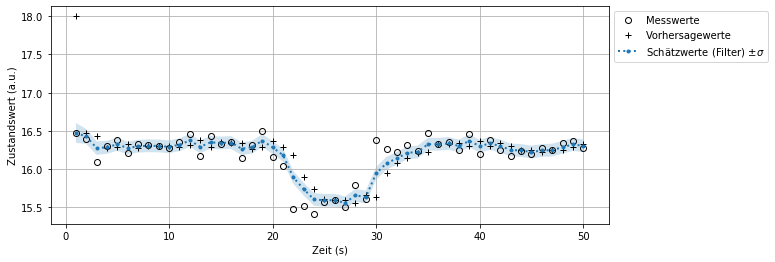

In [14]:
np.random.seed(10)

true_voltage = 16.3 # true value of constant temperature
voltage_std = 0.13 # try different values, nominal value 0.13
process_mean = 0.0 # mean of movement, try different values, nominal value 0.0
process_var = 0.005 # variance of movement, try different values, nominal value 0.005

x_start = gaussian(18., 1000.) # initial state
process_model = gaussian(process_mean, process_var)
z_vars = voltage_std**2

N = 50 # must be greater than 10
z_vals = [volt(true_voltage , voltage_std) for i in range(N)]
for i in range(N//2-4, N//2+4):
    z_vals[i] = volt(true_voltage*0.95 , voltage_std) # intermediate small temperature drop due to open window
plot_meas_pred_est(*kal_filt(z_vals, z_vars, x_start, process_model))

Das Festlegen des Parameters ``process_var`` ist demnach die schwerste Aufgabe in diesem Beispiel:  
**Frage:** Welche Schwankungen sind z.B. durch das Lüften zu erwarten? Wie groß darf man diesen Parameter wählen, damit der Filter nicht dem Sensorrauschen folgt?  
**Antwort:** Entscheidend ist für den Filter die Information über das Sensorrauschen ``voltage_std``: Nur wenn dieser Wert stimmt, dann werden die Messwerte auch mit einer angemessenen Signifikanz in den Filter mit einbezogen. Ist der Wert zu hoch, dann wird dem Sensor zu wenig vertraut. Ist der Wert zu klein, dann wird das Sensorrauschen fälschlicherweise als echte Temperaturschwankung interpretiert.

## Fixed Gain Kalman-Filter

Bei den Simulationen zum Roboterfahrzeug, wo für jede Iteration die verschiedenen Werte des Filters in Textform ausgegeben werden, war auffällig, dass die Varianzen der Messwerte und der Vorhersagewerte jeweils zu einem bestimmten Wert hin konvergierten. Dies liegt daran, dass konstante Varianzen für den Sensor und für das Prozessmodell verwendet wurden.  

Sind diese Konvergenzwerte bekannt, dann kann man auch einen Kalman-Filter mit konstantem fest vorgegebenem Gain implementieren. Dann muss man aber auch den Filter mit einem guten Startwert initialisieren.

In diesem Fall würde sich der Quellcode wie folgt vereinfachen:

```python
def update(x, z):
    K = const  # experimentally derived Kalman gain
    y = z - x   # residual
    x = x + K*y # posterior
    return x
    
def predict(x):
    return x + dx
```

Bei preissensiblen Anwendungen kann man so Kosten für die Hardware einsparen. 